# atelier.lumfunfit - Introduction
### Introduction to the Atelier's luminosity function fit classwith a strong emphasis on quasar luminosity functions

This notebook leads through an example of using the luminosity functio fit class to determine the free parameters of a luminosity function. 

The luminosity function fit uses MCMC (emcee) to sample the free parameters space minimizing the negative logarithmic likelihood defined in Marshall et al. (1983) Equation 3.

ADS reference: https://ui.adsabs.harvard.edu/abs/1983ApJ...269...35M/abstract

In [1]:
# General imports 
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Importing the atelier modules
from atelier import lumfun
from atelier import lumfunfit
from atelier import survey

## 1) Setting up the mock data
We start by generating a mock sample of quasars adopting the McGreer+2018 quasar luminosity function at z~5. Using the lumfun class method ".sample" we generate quasars in 10000 square degrees over the defined luminosity and redshift range. 

**Note:** The sample method relies on a large number of computational operations and has not been optimized, yet. So executing the function will take time.

[INFO]---------------------------------------------------
[INFO] Performing initialization checks 
[INFO]---------------------------------------------------
[INFO]---------------------------------------------------
[INFO] Main parameter phi_star is described by a function.
[INFO] The function parameters are: ['redsh', 'log_phi_star_z6', 'k', 'z_ref']
[INFO] All parameters are supplied.
[INFO] Parameters "lum" and "redsh" were ignored as they are luminosity function arguments.
[INFO]---------------------------------------------------
[INFO] Main parameter lum_star is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Main parameter alpha is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Main parameter beta is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Initialization check passed.
[INFO]---------------------------------------------------
[I

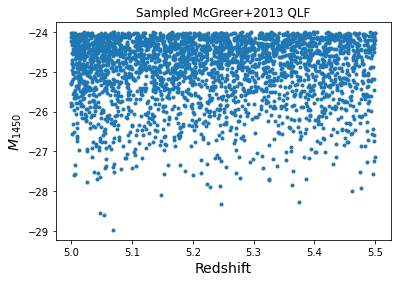

In [2]:
cosmology = FlatLambdaCDM(H0=70, Om0=0.272)

lum_range = [-29, -24]
redsh_range = [5.0, 5.5]
sky_area = 10000

mcgreer2018 = lumfun.McGreer2018QLF()

sample_M, sample_z = mcgreer2018.sample(lum_range, redsh_range, cosmology, sky_area)
mock_df = pd.DataFrame(data={'absmag':sample_M, 'redsh':sample_z})

plt.plot(sample_z, sample_M, '.')
plt.xlabel('Redshift', fontsize=14)
plt.ylabel('$M_{1450}$', fontsize=14)
plt.title('Sampled McGreer+2013 QLF')
plt.show()

## 2) Setting up the survey class
The mock quasar sample in M1450 and redshift will now be stored in the "Survey" class of the *survey* module. The "Survey" class is a container for important information of an astronomical survey such as the luminosity and redshift of it's sources and the overall survey area. As a keyword argument a selection function (see *selfun* module) can also be passed. 

In [3]:
mock_survey = survey.Survey(mock_df, 'absmag', 'redsh', 10000)

## 3) Fitting the mock survey to a luminosity function model
### 3.1) Instantiating the luminosity function fit class 
We begin by instantiating a LuminosityFunctionFit object before. The luminosity and redshift range for the fit are specified at this instance along with the cosmology and the list of surveys, whose data should be considered in the fit. For this example we only pass the mock_survey object we generated above.

In [4]:
fit = lumfunfit.LuminosityFunctionFit([-29, -24],[5.0,5.5], cosmology, [mock_survey])

### 3.2) Setting up the luminosity function model for the fit
In the next step we define the quasar luminosity function model used in the fit. Our goal is to reproduce the values of the McGreer+2018 quasar luminosity function. So we begin by instantiating a new version of it.

In [5]:
lfmodel = lumfun.McGreer2018QLF()
lfmodel.print_parameters()

[INFO]---------------------------------------------------
[INFO] Performing initialization checks 
[INFO]---------------------------------------------------
[INFO]---------------------------------------------------
[INFO] Main parameter phi_star is described by a function.
[INFO] The function parameters are: ['redsh', 'log_phi_star_z6', 'k', 'z_ref']
[INFO] All parameters are supplied.
[INFO] Parameters "lum" and "redsh" were ignored as they are luminosity function arguments.
[INFO]---------------------------------------------------
[INFO] Main parameter lum_star is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Main parameter alpha is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Main parameter beta is supplied as a normal parameter.
[INFO]---------------------------------------------------
[INFO] Initialization check passed.
[INFO]---------------------------------------------------
Pa

However, we need to modify the luminosity function parameters for the luminosity function fit. We begin by excluding three parameters from the fitting, which were fixed in the original quasar luminosity function determination. Technically we should also be able to reproduce these parameters, but we want to keep the example simple. 

Next, we set fitting bounds to the other three parameters and set their values to an arbitrary value within the fitting bounds for the initialization of the fit. Now we are ready to carry out the fit.

In [6]:
# Set the parameters that are fixed in the model to not be varied during the fit.
lfmodel.parameters['z_ref'].vary=False
lfmodel.parameters['k'].vary=False
lfmodel.parameters['beta'].vary=False

# Set the parameter bounds for the fit parameters and set the starting value
lfmodel.parameters['log_phi_star_z6'].bounds = [-11,-7]
lfmodel.parameters['log_phi_star_z6'].value = -8
lfmodel.parameters['lum_star'].bounds = [-29.5, -25.5]
lfmodel.parameters['lum_star'].value = -28
lfmodel.parameters['alpha'].bounds = [-3, -1]
lfmodel.parameters['alpha'].value = -1.5

lfmodel.print_parameters()

Parameter log_phi_star_z6 = -8, bounds=[-11, -7], vary=True, unc=[0.18, 0.15]
Parameter lum_star = -28, bounds=[-29.5, -25.5], vary=True, unc=[0.26, 0.22]
Parameter alpha = -1.5, bounds=[-3, -1], vary=True, unc=[0.09, 0.09]
Parameter beta = -4.0, bounds=None, vary=False, unc=None
Parameter k = -0.47, bounds=None, vary=False, unc=None
Parameter z_ref = 6, bounds=None, vary=False, unc=None


### 3.3) Fitting the luminosity function model
To carry out the fit we call the *.run_mcmc* function supplying the luminosity function model and the number of steps for the MCMC chain. Default values for the MCMC are specified as attributes of the LuminosityFunctionFit class, are be set during initialization and can be modified at any time. 

A bar indicates the progress of the MCMC sampling.

In [ ]:
fit.run_mcmc(lfmodel,steps=5000)

The *sampler* attribute of the LuminosityFunctionFit class holds all the information on the emcee sampler including the chain of samples. We can visualize the result of the fit by using emcee's sampler function to return a flat chain from the MCMC. 

Using the *corner* package we plot the results of the MCMC for the three fitted parameters highlighting the true input values of the McGreer+2018 QLF from which the mock sample was created.

In [ ]:
# Plotting the covariance matrices of the final fit parameters

flat_samples = fit.sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples)
labels=['log_phi_star', 'lum_star', 'alpha']
fig = corner.corner(flat_samples, labels=labels, truths=[-8.97, -27.47, -1.97])
print(np.nanpercentile(flat_samples[:,0],[16,50,84]))
print(np.nanpercentile(flat_samples[:,1],[16,50,84]))
print(np.nanpercentile(flat_samples[:,2],[16,50,84]))

The fitting results encompass the true input values within 1 sigma, while being biased slightly higher in all three parameters. At present, we suspect the luminosity function method *.sample* to be at the root of this issue as changing the sampling resolution affects is know to bias the fitting results. However, investigations are still ongoing.

## 4) Fitting the mock survey to a luminosity function model (multiprocessing!)
Depending on the number of object in the survey and the complexity of the luminosity function model, the MCMC fitting can take a few minutes. To speed up the progress we have implemented a special version of the MCMC fitting, making use of emcee's native multiprocessing abilities. 

The following cells provide a guide on how multiprocessing can be used to accelerate the fitting. The results initialized with the same default seed of the LuminosityFunctionFit class reproduce the result of the single core approach above.

In [11]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

12 CPUs


In [12]:
# Reset the initial guess
initial_guess = [-8, -28, -1.5]
# Run the MCMC chain
fit.run_mcmc_multiprocess(lfmodel, steps=5000, initial_guess=initial_guess,
                          processes=6)

100%|██████████| 5000/5000 [04:13<00:00, 19.72it/s]


[INFO] Multiprocessing took 253.6 seconds


[-9.01793936 -8.91553535 -8.82203563]
[-27.57611104 -27.40140614 -27.24798913]
[-1.97995996 -1.94293035 -1.90479171]


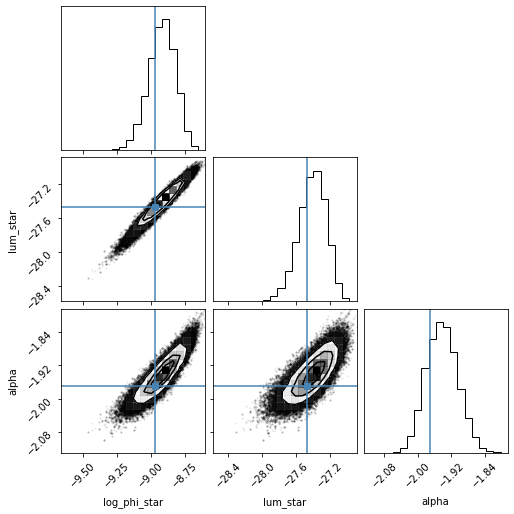

In [13]:
# Plotting the covariance matrices of the final fit parameters

flat_samples = fit.sampler.get_chain(discard=100, thin=1, flat=True)
labels=['log_phi_star', 'lum_star', 'alpha']
fig = corner.corner(flat_samples, labels=labels, truths=[-8.97, -27.47, -1.97])
print(np.nanpercentile(flat_samples[:,0],[16,50,84]))
print(np.nanpercentile(flat_samples[:,1],[16,50,84]))
print(np.nanpercentile(flat_samples[:,2],[16,50,84]))

## 5) Fitting a luminosity function to multiple surveys

In [ ]:
mock_survey1 = survey.Survey(mock_df[:int(mock_df.shape[0]/2)], 'absmag', 'redsh',
                      5000)
mock_survey2 = survey.Survey(mock_df[int(mock_df.shape[0]/2):], 'absmag', 'redsh',
                      5000)

In [ ]:
fit2 = lumfunfit.LuminosityFunctionFit([-29, -24],[5.0,5.5], cosmology, [mock_survey1,
                                                              mock_survey2])

In [ ]:
initial_guess = [-8, -28, -1.5]
# Run the MCMC chain
fit2.run_mcmc(lfmodel, steps=5000, initial_guess=initial_guess)

In [ ]:
# Plotting the covariance matrices of the final fit parameters

flat_samples = fit2.sampler.get_chain(discard=100, thin=1, flat=True)
labels=['log_phi_star', 'lum_star', 'alpha']
fig = corner.corner(flat_samples, labels=labels, truths=[-8.97, -27.47, -1.97])
print(np.nanpercentile(flat_samples[:,0],[16,50,84]))
print(np.nanpercentile(flat_samples[:,1],[16,50,84]))
print(np.nanpercentile(flat_samples[:,2],[16,50,84]))

## 6) Fitting the mock survey to a luminosity function model (integration mode: "simpson")

In [7]:
fit = lumfunfit.LuminosityFunctionFit([-29, -24],[5.0,5.5], cosmology, [mock_survey])

In [8]:
# Reset the initial guess
initial_guess = [-8, -28, -1.5]
# Run the MCMC chain
fit.run_mcmc(lfmodel, steps=5000, initial_guess=initial_guess, int_mode='simpson')

100%|██████████| 5000/5000 [02:13<00:00, 37.38it/s]


[-9.01302699 -8.91593096 -8.82950664]
[-27.57408329 -27.40910229 -27.26364548]
[-1.97509396 -1.94016805 -1.90512569]


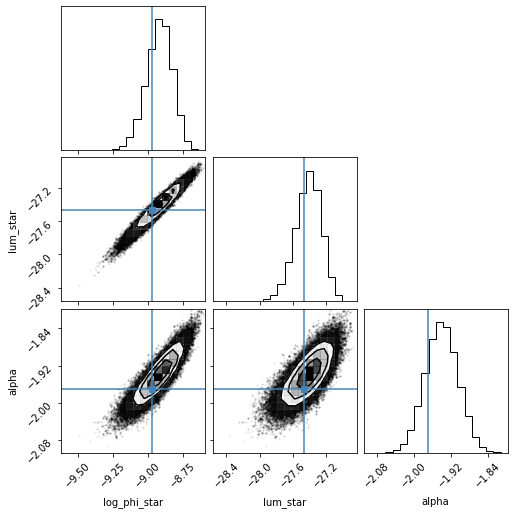

In [10]:
# Plotting the covariance matrices of the final fit parameters

flat_samples = fit.sampler.get_chain(discard=100, thin=1, flat=True)
# print(flat_samples)
labels=['log_phi_star', 'lum_star', 'alpha']
fig = corner.corner(flat_samples, labels=labels, truths=[-8.97, -27.47, -1.97])
print(np.nanpercentile(flat_samples[:,0],[16,50,84]))
print(np.nanpercentile(flat_samples[:,1],[16,50,84]))
print(np.nanpercentile(flat_samples[:,2],[16,50,84]))